In [14]:
# %%
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
SIM_TIME = 100000
ARRIVAL_RATE = 1/5 # fixed average inter-arrival time
BUFFER_SIZE = 10       # shared total capacity (adjusted in separate mode)
SERVICE_RATES = [round(x, 2) for x in np.linspace(0.08, 0.25, 18)]
SEED = 42
TYPE1 = 1

In [16]:
class Measure:
    def __init__(self):
        self.arr = 0
        self.dep = 0
        self.ut = 0
        self.oldT = 0
        self.delay = 0
        self.bs1 = 0
        self.bs2 = 0
        self.loss = 0

In [17]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time


- both arrival and departure simulate behavior differently for shared and separate buffers 
- shared => one global queue MM1 => two servers can pick from it 
- Separate => two independent queues MM1 and MM2 => assigned randomly  

In [18]:
def simulate_buffer_config(service_rate, shared=True):
    global users, data, MM1, MM2, busy1, busy2
    users = 0
    data = Measure()
    MM1 = []
    MM2 = []
    time = 0
    busy1 = False
    busy2 = False
    start_time_1 = None
    start_time_2 = None

    FES = PriorityQueue()
    random.seed(SEED)

    def arrival(current_time):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2

        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL_RATE)
        FES.put((current_time + inter_arrival, "arrival"))

        if shared:
            if users < BUFFER_SIZE:
                users += 1
                MM1.append(Client(TYPE1, current_time))

                if not busy1:
                    s_time = random.expovariate(service_rate)
                    start_time_1 = current_time
                    FES.put((current_time + s_time, "departure1"))
                    busy1 = True
                elif not busy2:
                    s_time = random.expovariate(service_rate)
                    start_time_2 = current_time
                    FES.put((current_time + s_time, "departure2"))
                    busy2 = True
            else:
                data.loss += 1
        else:
            per_server_buffer = BUFFER_SIZE // 2
            target = 1 if random.random() < 0.5 else 2
            queue = MM1 if target == 1 else MM2
            if len(queue) < per_server_buffer:
                queue.append(Client(TYPE1, current_time))
                users += 1
                if target == 1 and not busy1:
                    s_time = random.expovariate(service_rate)
                    start_time_1 = current_time
                    FES.put((current_time + s_time, "departure1"))
                    busy1 = True
                elif target == 2 and not busy2:
                    s_time = random.expovariate(service_rate)
                    start_time_2 = current_time
                    FES.put((current_time + s_time, "departure2"))
                    busy2 = True
            else:
                data.loss += 1

    def departure(current_time, server_id):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2

        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        if shared:
            if MM1:
                client = MM1.pop(0)
                data.delay += (current_time - client.arrival_time)
                users -= 1
                if MM1:
                    s_time = random.expovariate(service_rate)
                    if server_id == 1:
                        data.bs1 += current_time - start_time_1
                        start_time_1 = current_time
                        FES.put((current_time + s_time, "departure1"))
                    else:
                        data.bs2 += current_time - start_time_2
                        start_time_2 = current_time
                        FES.put((current_time + s_time, "departure2"))
                else:
                    if server_id == 1:
                        data.bs1 += current_time - start_time_1
                        busy1 = False
                    else:
                        data.bs2 += current_time - start_time_2
                        busy2 = False
        else:
            queue = MM1 if server_id == 1 else MM2
            if queue:
                client = queue.pop(0)
                data.delay += (current_time - client.arrival_time)
                users -= 1
                if queue:
                    s_time = random.expovariate(service_rate)
                    if server_id == 1:
                        data.bs1 += current_time - start_time_1
                        start_time_1 = current_time
                        FES.put((current_time + s_time, "departure1"))
                    else:
                        data.bs2 += current_time - start_time_2
                        start_time_2 = current_time
                        FES.put((current_time + s_time, "departure2"))
                else:
                    if server_id == 1:
                        data.bs1 += current_time - start_time_1
                        busy1 = False
                    else:
                        data.bs2 += current_time - start_time_2
                        busy2 = False

    FES.put((0, "arrival"))
    while time < SIM_TIME:
        (time, event_type) = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * 2)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0

    return delay, avg_users, utilization, loss_rate


In [19]:
results = []
for servicetime in SERVICE_RATES:
    shared = simulate_buffer_config(1 / servicetime, shared=True)
    separate = simulate_buffer_config(1 / servicetime, shared=False)
    results.append({
        'Service Rate': servicetime,
        'Type': 'Shared',
        'Avg Delay': shared[0],
        'Avg Users': shared[1],
        'Utilization': shared[2],
        'Loss Rate': shared[3]
    })
    results.append({
        'Service Rate': servicetime,
        'Type': 'Separate',
        'Avg Delay': separate[0],
        'Avg Users': separate[1],
        'Utilization': separate[2],
        'Loss Rate': separate[3]
    })


In [20]:
df_results = pd.DataFrame(results)
print(df_results)


    Service Rate      Type  Avg Delay  Avg Users  Utilization  Loss Rate
0           0.08    Shared   0.132848   0.663881     0.199539   0.000050
1           0.08  Separate   0.099968   0.500262     0.200179   0.000288
2           0.09    Shared   0.162771   0.813969     0.224812   0.000144
3           0.09  Separate   0.116083   0.580163     0.225243   0.000408
4           0.10    Shared   0.199609   0.998322     0.249934   0.000482
5           0.10  Separate   0.132517   0.661598     0.249617   0.000727
6           0.11    Shared   0.242557   1.213984     0.275539   0.001323
7           0.11  Separate   0.150650   0.752582     0.274744   0.001062
8           0.12    Shared   0.291950   1.456531     0.299043   0.002489
9           0.12  Separate   0.169914   0.849247     0.299891   0.001704
10          0.13    Shared   0.355439   1.770838     0.323877   0.004975
11          0.13  Separate   0.190275   0.949612     0.324476   0.002435
12          0.14    Shared   0.430663   2.138969   

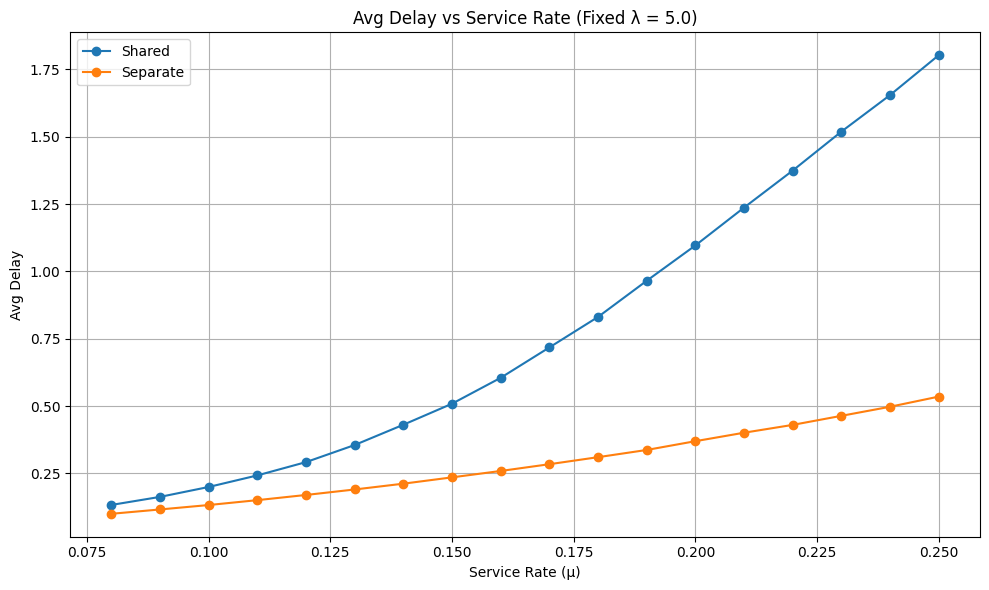

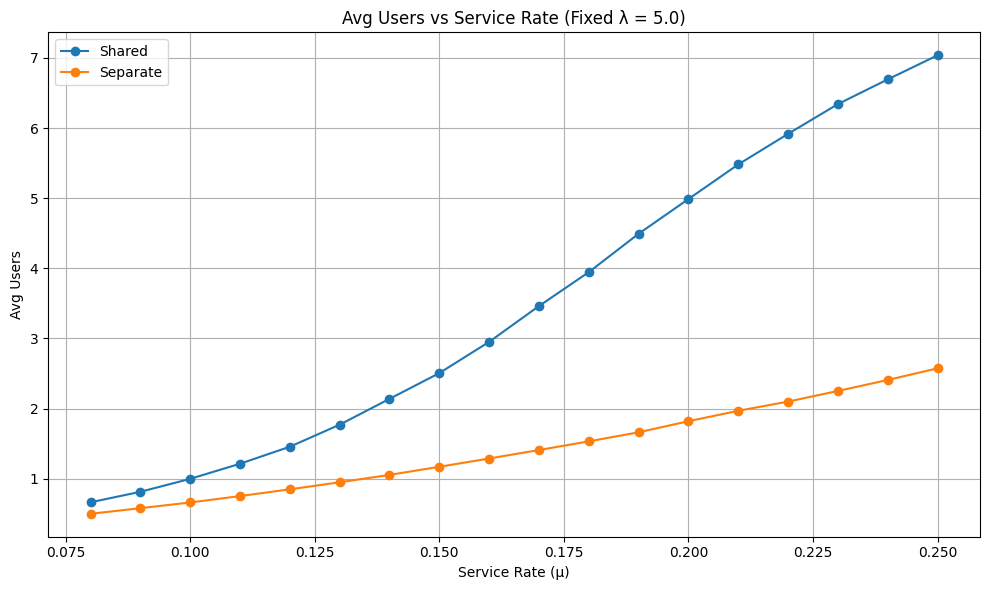

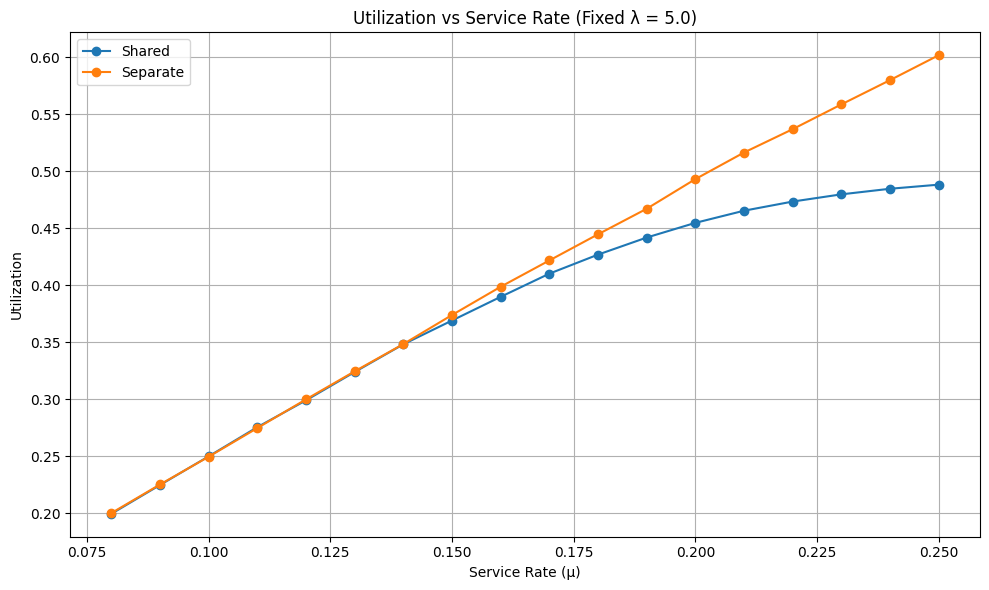

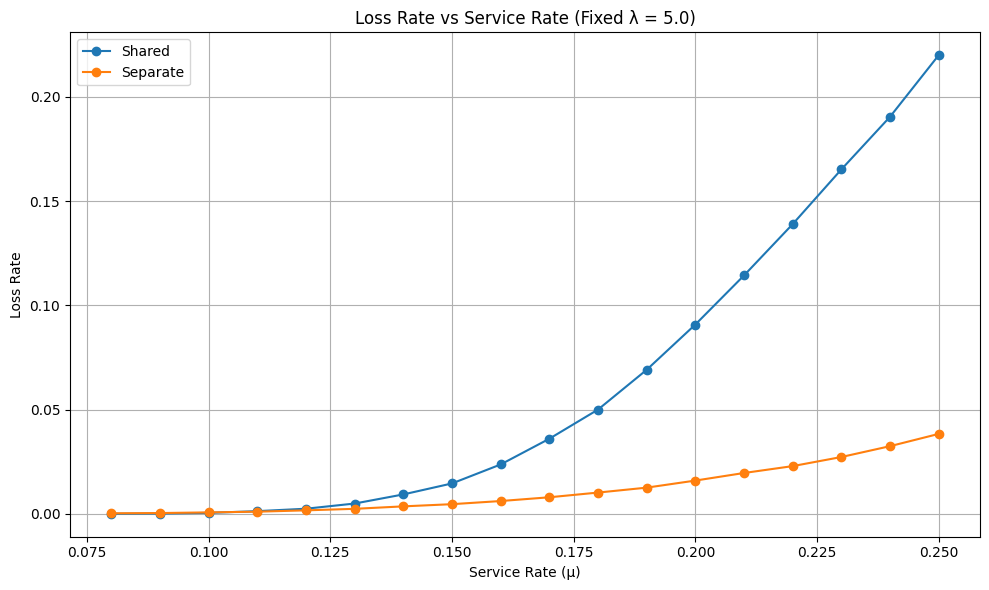

In [21]:
metrics = ['Avg Delay', 'Avg Users', 'Utilization', 'Loss Rate']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for t in ['Shared', 'Separate']:
        subset = df_results[df_results['Type'] == t]
        plt.plot(subset['Service Rate'], subset[metric], marker='o', label=t)
    plt.title(f'{metric} vs Service Rate (Fixed λ = {1/ARRIVAL_RATE})')
    plt.xlabel('Service Rate (μ)')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1 chart : Avg Delay vs Service rate (shared vs Separate Buffer)- fixed arrival rate = 10 

- a shared finite buffer and separate finite buffers (one per servre)
- the arrival rate is fixed while the service rate μ was varied to analyze its impact on average system delay. 
- the result show an inverse relationship btw service rate and average delay - as service rate increased, the avg delay decreased consistently for both config 
- this alligns with the queuing theory expectations, as faster servers, reducing congestion
- both systems behave nearly identical across all tested values of μ
- implies that under balanced and stable load => the choice of buffer architecture has mini effect on delay performance  

# Average Users VS Service Rate 

- the result confirms thate increasing the service rate significantly reduces the avg number of users in the system

- this is also consistent with the queueing theory where faster servers reduce waiting time and queue build up

- across all service rates => the shared buffer system maintained slightly higher occupancy than the separate buffer system, particularly at lower service rates 

- likely due to the centralized nature of the shared buffer which can accomodate more users before losing them 


# Utilization VS Service rate 

- Utilization defined as the fraction of time servers are busy, shows a decreasing trend as the service rate increases 

- this is expected as fater server completes the job leading to the more idle time and reduce cumulative utilization 

- the separate buffer config consistently exhibits higher utilization than the shared buffer setup acorss all service rates.

- in separate systems => each server independently stays active when the overall system load is light 

- shares buffer may occasionally underutilize the one server if load balancing is uneven 

- overall, both systems become less utilized at higher service rates, but the separate config maintain slightly more balanced workload per server


# Loss rate VS Service rate 

- loss rate sharply decreases at higher service rates since faster servers can process packets before buffer overflows 

- shared buffer expricence higher loss rate at lower service rates
- bc both servers drawn from the same limited space 

- the separate buffer setup maintain almost negligible loss rate across all tested service rates => more efficient handling of traffic by isolating queue overflow risks 

- separate buffers offer greater resilience to the packet loss, especially when the service capacity is limited 

*** if both servers are busy and the buffer is full => every new arrival is lost in the shared buffer 

*** but in separate buffer => overflow in one doesn't effect the other and it cajn serve the new arrival 